# Music genre prediction

## Вводная информация

### Описание задачи

Музыкальный сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Наши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Наша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [2]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
# !pip install catboost
# !pip install feature-engine
# !pip install imbalanced-learn

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from catboost import CatBoostClassifier
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from phik.report import plot_correlation_matrix
from phik import report
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder, StandardScaler, OneHotEncoder,
                                   MinMaxScaler, LabelEncoder, RobustScaler, PolynomialFeatures)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, shuffle
from sklearn.utils import shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [4]:
try:
    train = pd.read_csv('kaggle_music_genre_train.csv')
except:
    train = pd.read_csv('/kaggle/input/the-kaggle-music-prediction-competition/kaggle_music_genre_train.csv')


In [5]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [7]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [9]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [10]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

7

In [11]:
train = train.drop_duplicates()

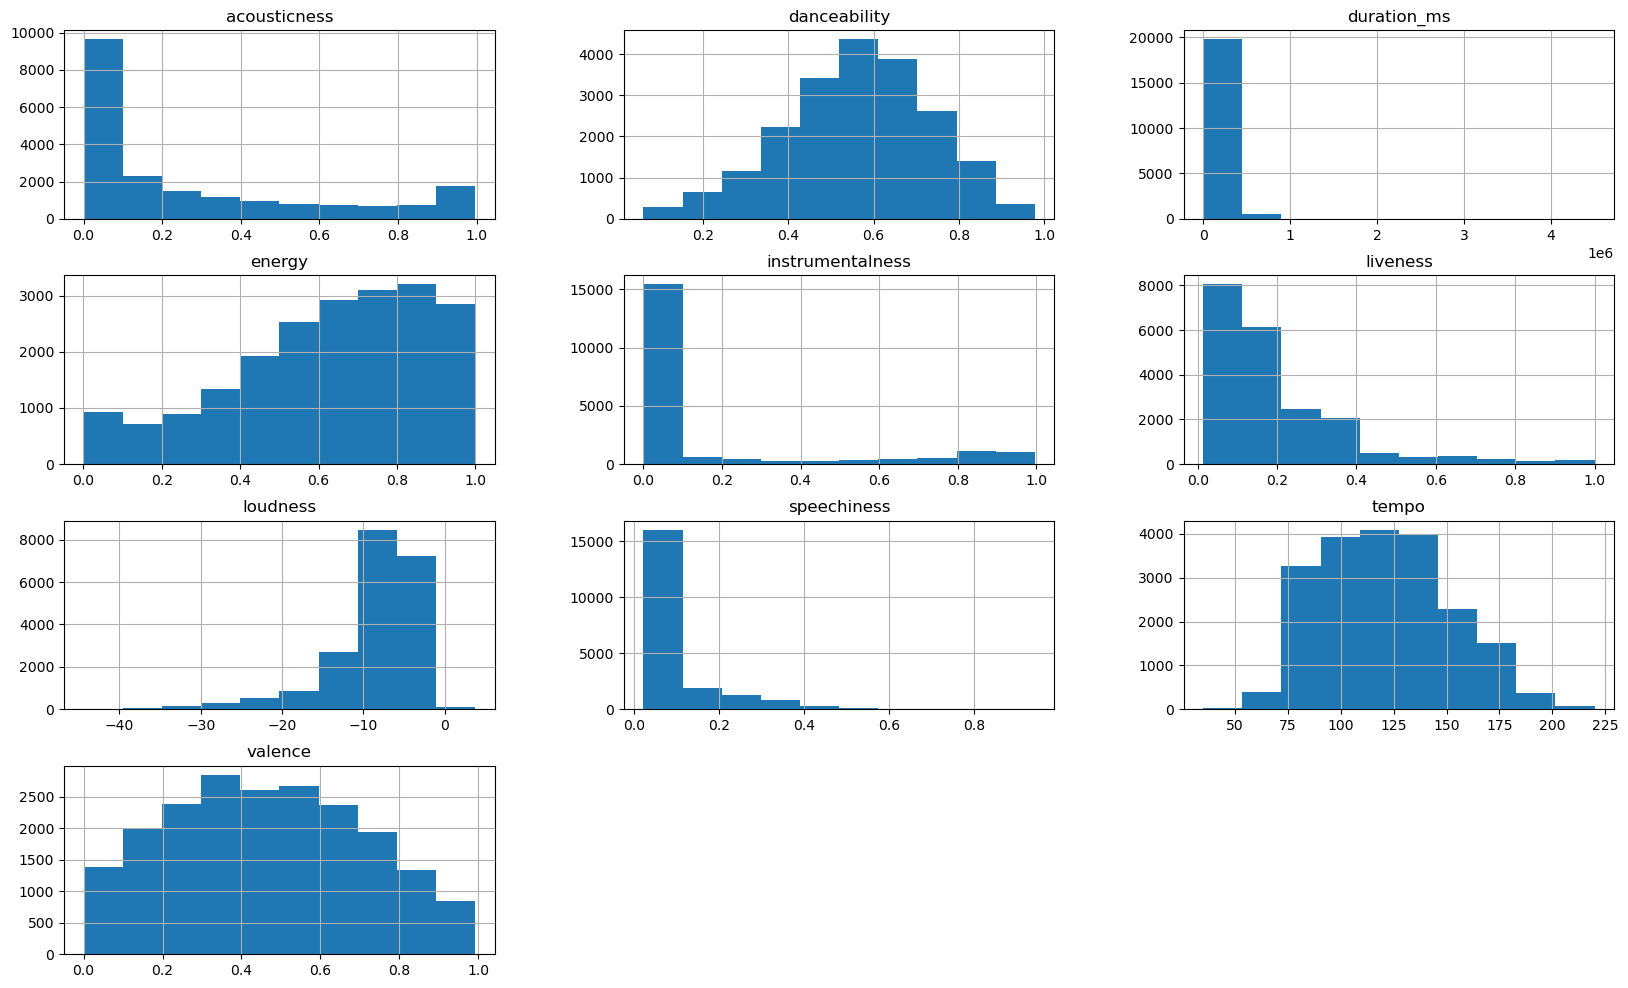

In [12]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

In [13]:
phik_overview = train.phik_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


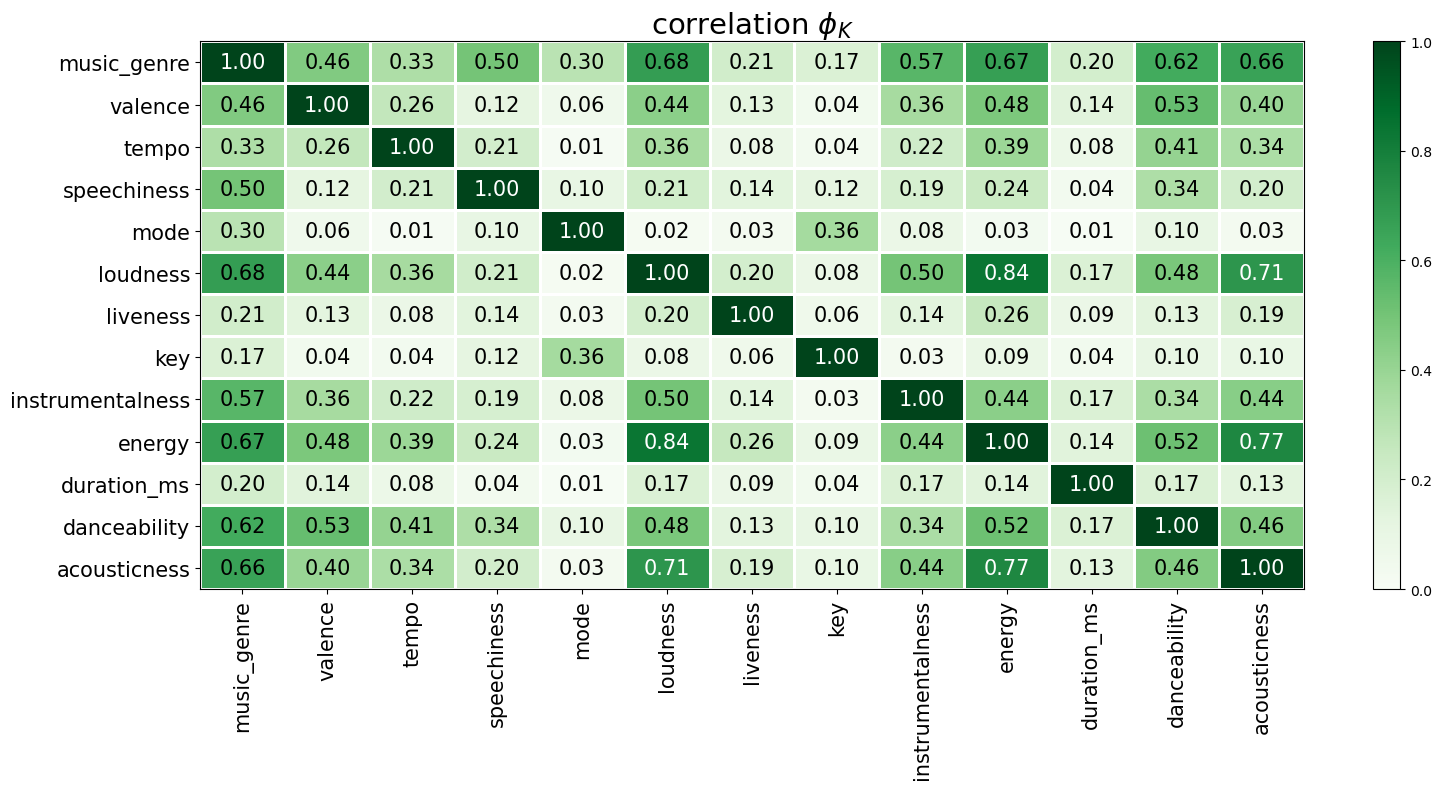

In [16]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [17]:
significance_overview = train.significance_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


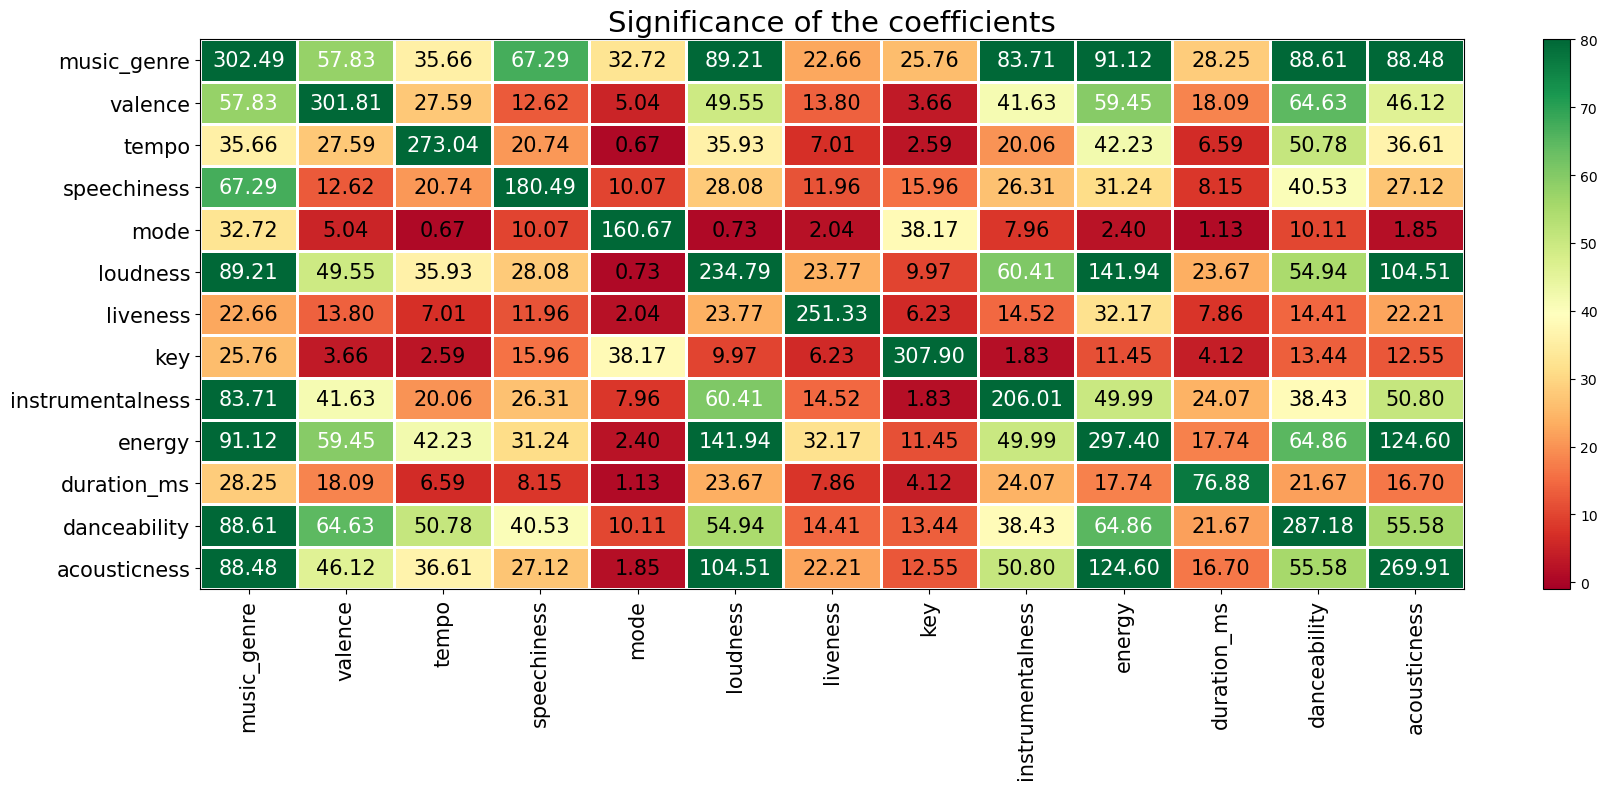

In [18]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

Заметна высокая корреляция между показателями:
music_genre - acousticness
music_genre - dancebility
music_genre - energy
music_genre - instrumentalness
music_genre - loudness
loudness - acousticness
loudness - energy
energy - acousticness

In [19]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


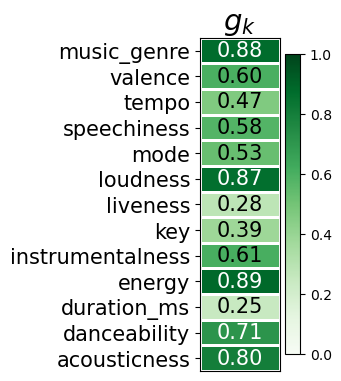

In [20]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

Так же заметна общая корреляция у фичей energy, loudness и acousticness

In [21]:
# train['combined_feature'] = (train['energy'] + train['loudness'] + train['acousticness']) / 3
# train = train.drop(['energy', 'loudness', 'acousticness'], axis=1)

Разработка новых синтетических признаков приводит к снижению f1-меры на 0.01 - 0.02 единицы. Поэтому в дальнейшем будем использовать только исходные признаки.

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20387 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20387 non-null  float64
 1   danceability      20387 non-null  float64
 2   duration_ms       20387 non-null  float64
 3   energy            20387 non-null  float64
 4   instrumentalness  20387 non-null  float64
 5   key               19653 non-null  object 
 6   liveness          20387 non-null  float64
 7   loudness          20387 non-null  float64
 8   mode              19881 non-null  object 
 9   speechiness       20387 non-null  float64
 10  tempo             19945 non-null  float64
 11  valence           20387 non-null  float64
 12  music_genre       20387 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.2+ MB


In [23]:
train.isna().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 734
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64

Есть пропуски в данных с ними будем работать внутри pipeline.

In [24]:
train['key'].value_counts() 

G     2303
C     2149
C#    2125
D     2109
A     2013
F     1615
B     1521
E     1516
G#    1267
A#    1223
F#    1206
D#     606
Name: key, dtype: int64

In [25]:
train['mode'].value_counts() 

Major    12826
Minor     7055
Name: mode, dtype: int64

In [26]:
train['music_genre'].value_counts() 

Blues          2857
Alternative    2601
Electronic     2559
Rap            2427
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

В данном блоке были протестированы следующие действия:
- Удален duration ниже 0
- Созданы агрегирующие фичи
- Удалены строки с наименьшей корреляцией с целевым признаком
- Удалены строки с наибольшей корреляцией с целевым признаком

Ничего из этого не повлеяло положительно не результаты предсказаний

## Подготовка данных к обучению моделей

### Pipeline

In [27]:
X = train.drop('music_genre', axis=1)
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

Пайплайн для числовых данных (num_pipeline) включает следующие этапы:

- Итеративное заполнение пропущенных значений (IterativeImputer) для числовых признаков. Этот метод использует информацию из других признаков для заполнения пропущенных значений.
- RobustScaler для масштабирования числовых признаков, чтобы сделать их более устойчивыми к выбросам.
- DropCorrelatedFeatures для удаления высококоррелированных признаков. Этот шаг может улучшить производительность модели, так как высокая корреляция между признаками может привести к мультиколлинеарности.
- PolynomialFeatures для добавления полиномиальных признаков второй степени. Это может помочь захватить нелинейные зависимости между признаками.
- DropConstantFeatures для удаления признаков с почти постоянными значениями. Эти признаки не несут полезной информации и могут замедлить обучение модели.

Пайплайн для категориальных данных (cat_pipeline) включает следующие этапы:

- Импутация пропущенных значений (SimpleImputer) для категориальных признаков. В данном случае, для замены пропущенных значений используется наиболее часто встречающееся значение в каждом признаке.
- OrdinalEncoder для кодирования категориальных признаков целыми числами. Этот метод преобразует уникальные значения категориальных признаков в числовые значения, сохраняя порядок между значениями.

### RandomizedSearchCV fitting

In [28]:
# # Создание модели CatBoostClassifier с поддержкой GPU
# clf = CatBoostClassifier(
#     task_type='GPU',
#     eval_metric='TotalF1'
# )

# # Определение Pipeline с шагами предобработки и моделью
# pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', clf)
# ])

# # Определение параметров для подбора гиперпараметров
# params = {
#     'model__depth': [4, 6, 8, 10],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__l2_leaf_reg': [1, 3, 5, 7],
#     'model__iterations': [100, 200, 300, 500],
#     'model__border_count': [5, 10, 20],
#     'model__thread_count': [4],
#     'model__early_stopping_rounds': [10],
#     'model__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
#     'model__random_strength': [0.01, 0.1, 1],
#     'model__max_ctr_complexity': [1, 2, 3]
# }

# # Создание RandomizedSearchCV
# grid = RandomizedSearchCV(pipeline,
#                           params,
#                           n_iter=50,
#                           cv=3,
#                           verbose=5,
#                           random_state=42,
#                           scoring='f1_micro',
#                           n_jobs=None)

# # Подгонка модели
# grid.fit(X_train, y_train)

# # Вывод лучших параметров и результатов
# print("Best Parameters:", grid.best_params_)
# print("Best F1 Micro Score:", grid.best_score_)

Лучший показатель модели CatBoostClassifier
- Best Parameters: {'model__thread_count': 4, 'model__random_strength': 1, 'model__max_ctr_complexity': 1, 'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 300, 'model__early_stopping_rounds': 10, 'model__depth': 4, 'model__border_count': 10, 'model__bootstrap_type': 'Bayesian'}
- Best F1 Micro Score: 0.4591481507101745

In [29]:
# lr = LogisticRegression(tol=0.01)

# pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', lr)
# ])

# param_dist = {
#     'model__C': np.logspace(-3, 3, 7),
#     'model__penalty': ['l1', 'l2'],
#     'model__solver': ['liblinear', 'saga']
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [30]:
# %%time
# grid.fit(X_train, y_train)

In [31]:
# grid.best_params_

In [32]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Лучший показатель модели LogisticRegression
- Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.1}
- Best F1 Micro Score:  0.43

In [33]:
# rfc = RandomForestClassifier()

# pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', rfc)
# ])

# param_dist = {
#     'model__n_estimators': [100, 200, 300],
#     'model__max_depth': [None, 5, 10]
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [34]:
# %%time
# grid.fit(X_train, y_train)

In [35]:
# grid.best_params_

In [36]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Лучший показатель модели RandomForestClassifier
- Best Parameters: {'model__n_estimators': 300, 'model__max_depth': 10}
- Best F1 Micro Score:  0.44

In [37]:
# mlpc = MLPClassifier()

# pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', mlpc)
# ])

# param_dist = {
#     'model__hidden_layer_sizes': [(100,), (200,), (300,)],
#     'model__activation': ['relu', 'tanh', 'logistic'],
#     'model__alpha': [0.0001, 0.001, 0.01]
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [38]:
# %%time
# grid.fit(X_train, y_train)

In [39]:
# grid.best_params_

In [40]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Лучший показатель модели MLPClassifier
- Best Parameters: {'model__hidden_layer_sizes': (100,),
 'model__alpha': 0.01,
 'model__activation': 'logistic'}
- Best F1 Micro Score:  0.30

### Выводы

Показатели F1 Micro для моделей.
- CatBoostClassifier: 0.46
- LogisticRegression: 0.43
- RandomForestClassifier: 0.44
- MLPClassifier: 0.30

Код закомментирован, так как RandomizedSearchCV проводился на облачном железе, но для подтверждения ниже будут проведены повторные предсказания с теми же параметрами.

### PipeLine prediction

In [41]:
cbc = CatBoostClassifier(
    thread_count=4,
    random_strength=1,
    max_ctr_complexity=1,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=300,
    early_stopping_rounds=10,
    depth=4,
    border_count=10,
    bootstrap_type='Bayesian'
)

cbc_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

cbc_pipeline.fit(X_train, y_train)
y_pred = cbc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

set_config(display='diagram')

0:	learn: 2.1947961	total: 133ms	remaining: 39.9s
1:	learn: 2.1206145	total: 180ms	remaining: 26.8s
2:	learn: 2.0664552	total: 226ms	remaining: 22.4s
3:	learn: 2.0209875	total: 274ms	remaining: 20.3s
4:	learn: 1.9836616	total: 322ms	remaining: 19s
5:	learn: 1.9491565	total: 424ms	remaining: 20.8s
6:	learn: 1.9195153	total: 729ms	remaining: 30.5s
7:	learn: 1.8936657	total: 798ms	remaining: 29.1s
8:	learn: 1.8680362	total: 902ms	remaining: 29.2s
9:	learn: 1.8437298	total: 977ms	remaining: 28.3s
10:	learn: 1.8225535	total: 1.06s	remaining: 28s
11:	learn: 1.8037821	total: 1.12s	remaining: 27s
12:	learn: 1.7877426	total: 1.18s	remaining: 26.1s
13:	learn: 1.7714934	total: 1.25s	remaining: 25.4s
14:	learn: 1.7566944	total: 1.34s	remaining: 25.4s
15:	learn: 1.7450222	total: 1.39s	remaining: 24.7s
16:	learn: 1.7338357	total: 1.48s	remaining: 24.6s
17:	learn: 1.7240144	total: 1.53s	remaining: 24.1s


18:	learn: 1.7129085	total: 1.6s	remaining: 23.7s
19:	learn: 1.7041692	total: 1.67s	remaining: 23.4s
20:	learn: 1.6931683	total: 1.73s	remaining: 23s
21:	learn: 1.6842307	total: 1.79s	remaining: 22.6s
22:	learn: 1.6752166	total: 1.94s	remaining: 23.4s
23:	learn: 1.6674193	total: 2s	remaining: 23s
24:	learn: 1.6595006	total: 2.05s	remaining: 22.5s
25:	learn: 1.6535653	total: 2.09s	remaining: 22s
26:	learn: 1.6472114	total: 2.12s	remaining: 21.5s
27:	learn: 1.6404854	total: 2.17s	remaining: 21.1s
28:	learn: 1.6339563	total: 2.21s	remaining: 20.6s
29:	learn: 1.6293955	total: 2.35s	remaining: 21.1s
30:	learn: 1.6226594	total: 2.4s	remaining: 20.8s
31:	learn: 1.6165713	total: 2.47s	remaining: 20.7s
32:	learn: 1.6116495	total: 2.54s	remaining: 20.6s
33:	learn: 1.6065951	total: 2.58s	remaining: 20.2s
34:	learn: 1.6027569	total: 2.62s	remaining: 19.8s
35:	learn: 1.5971066	total: 2.66s	remaining: 19.5s
36:	learn: 1.5917342	total: 2.71s	remaining: 19.3s
37:	learn: 1.5875932	total: 2.75s	remainin

In [42]:
lr = LogisticRegression(tol=0.01, solver='liblinear', penalty='l1', C=0.1)
lr_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', lr)
])

lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.45


In [43]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=10)

rfc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', rfc)
])

rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.45


In [44]:
mlpc = MLPClassifier(hidden_layer_sizes=(100,),
                    alpha=0.01,
                    activation='logistic')

mlpc_pipeline = Pipeline(steps=[
    ('pipeline', col_trans),
    ('model', mlpc)
])

mlpc_pipeline.fit(X_train, y_train)
y_pred = mlpc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

f1_micro = 0.45


/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Показатели F1 Micro для моделей с лучшими параметрами.
- CatBoostClassifier: 0.47
- LogisticRegression: 0.45
- RandomForestClassifier: 0.45
- MLPClassifier: 0.45

## Проводим финальное тестирование

In [45]:
try:
    test = pd.read_csv('kaggle_music_genre_test.csv')
except:
    train = pd.read_csv('/kaggle/input/the-kaggle-music-prediction-competition/kaggle_music_genre_train.csv')


In [46]:
tes1 = test

In [47]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [48]:
f = train.drop('music_genre', axis=1)
t = train['music_genre']

In [49]:
cbc_pipeline.fit(f, t)
y_pred = cbc_pipeline.predict(test)

y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('cbc_pipeline.csv', index=False)

0:	learn: 2.1971104	total: 29.3ms	remaining: 8.76s
1:	learn: 2.1242015	total: 55.1ms	remaining: 8.2s
2:	learn: 2.0716629	total: 79.1ms	remaining: 7.83s
3:	learn: 2.0264872	total: 107ms	remaining: 7.93s
4:	learn: 1.9858607	total: 133ms	remaining: 7.87s
5:	learn: 1.9496500	total: 165ms	remaining: 8.1s
6:	learn: 1.9149533	total: 195ms	remaining: 8.17s
7:	learn: 1.8955051	total: 221ms	remaining: 8.05s
8:	learn: 1.8707025	total: 256ms	remaining: 8.28s
9:	learn: 1.8492668	total: 281ms	remaining: 8.16s
10:	learn: 1.8301706	total: 308ms	remaining: 8.1s
11:	learn: 1.8082219	total: 338ms	remaining: 8.12s
12:	learn: 1.7907657	total: 366ms	remaining: 8.07s
13:	learn: 1.7744012	total: 396ms	remaining: 8.09s
14:	learn: 1.7596558	total: 421ms	remaining: 8.01s
15:	learn: 1.7454082	total: 454ms	remaining: 8.06s
16:	learn: 1.7318538	total: 484ms	remaining: 8.06s
17:	learn: 1.7224647	total: 516ms	remaining: 8.08s
18:	learn: 1.7101931	total: 547ms	remaining: 8.08s
19:	learn: 1.7016075	total: 571ms	remaini

### Выводы

Показатели F1 Micro для моделей с лучшими параметрами на Kaggle.
- CatBoostClassifier: 0.496
- LogisticRegression: 0.454
- RandomForestClassifier: 0.457
- MLPClassifier: 0.461